In [1]:
import uproot4
import awkward1 as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep
import numba as nb
import scipy.constants
import h5py

In [2]:
#plt.style.use(mplhep.style.CMS)

In [3]:
def select_events( events, apply_exclusive=True ):

    selections_ = []
    counts_ = []

    msk_2muons = ( events.nMuonCand >= 2 )
    events_2muons = events[msk_2muons]
    
    dphi = events_2muons.MuonCand.phi[:,0] - events_2muons.MuonCand.phi[:,1]
    
    dphi = np.where( dphi >=  scipy.constants.pi, dphi - 2*scipy.constants.pi, dphi)
    dphi = np.where( dphi <  -scipy.constants.pi, dphi + 2*scipy.constants.pi, dphi)
    acopl = 1. - np.abs(dphi)/scipy.constants.pi

    events_2muons["Acopl"] = acopl

    m1 = events_2muons.MuonCand[:,0]
    m2 = events_2muons.MuonCand[:,1]

    invariant_mass = np.sqrt( 2*m1.pt*m2.pt*( np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi) ) )

    events_2muons["InvMass"] = invariant_mass

    energy_com = 13000.
    xi_mumu_plus = (1./energy_com) * ( m1.pt*np.exp(m1.eta) + m2.pt*np.exp(m2.eta) )
    xi_mumu_minus = (1./energy_com) * ( m1.pt*np.exp(-m1.eta) + m2.pt*np.exp(-m2.eta) )

    events_2muons["XiMuMuPlus"] = xi_mumu_plus
    events_2muons["XiMuMuMinus"] = xi_mumu_minus

    pfCands_ = events_2muons.PfCand

    pfCands_["dR_0"] = np.sqrt( ( pfCands_.eta - events_2muons.MuonCand.eta[:,0] )**2 + ( pfCands_.phi - events_2muons.MuonCand.phi[:,0] )**2 )
    pfCands_["dR_1"] = np.sqrt( ( pfCands_.eta - events_2muons.MuonCand.eta[:,1] )**2 + ( pfCands_.phi - events_2muons.MuonCand.phi[:,1] )**2 )

    pfCands_sel1_ = pfCands_[
                    pfCands_.fromPV == 3.0 
                    ]
    pfCands_sel2_ = pfCands_sel1_[
                    pfCands_sel1_.dR_0 > 0.3 
                    ]
    pfCands_sel3_ = pfCands_sel2_[
                    pfCands_sel2_.dR_1 > 0.3 
                    ]
    events_2muons[ "nExtraPfCandPV3" ] = ak.num( pfCands_sel3_ )

    #msk  = ( np.array( events_sel1.MuonCand.pt[:,0] >= 50. ) & np.array( events_sel1.MuonCand.pt[:,1] >= 50. ) &
    #         np.array( events_sel1.MuonCand.istight[:,0] == 1 ) & np.array( events_sel1.MuonCand.istight[:,1] == 1 ) &
    #         np.array( ( events_sel1.MuonCand.charge[:,0] * events_sel1.MuonCand.charge[:,1] ) == -1 ) &
    #         np.array( np.abs( events_sel1.MuonCand.vtxz[:,0] - events_sel1.PrimVertexCand.z[:,0] ) <= 0.02 ) &
    #         np.array( np.abs( events_sel1.MuonCand.vtxz[:,1] - events_sel1.PrimVertexCand.z[:,0] ) <= 0.02 ) ) 
    msk_muon = ( np.array( events_2muons.MuonCand.pt[:,0] >= 50. ) & np.array( events_2muons.MuonCand.pt[:,1] >= 50. ) &
                 np.array( events_2muons.MuonCand.istight[:,0] == 1 ) & np.array( events_2muons.MuonCand.istight[:,1] == 1 ) &
                 np.array( ( events_2muons.MuonCand.charge[:,0] * events_2muons.MuonCand.charge[:,1] ) == -1 ) )
    selections_.append( "Muon" )
    counts_.append( np.sum( msk_muon ) )
    
    msk_vtx = msk_muon & ( np.array( np.abs( events_2muons.PrimVertexCand.z[:,0] ) <= 15. ) &
                           np.array( np.abs( events_2muons.MuonCand.vtxz[:,0] - events_2muons.PrimVertexCand.z[:,0] ) <= 0.02 ) &
                           np.array( np.abs( events_2muons.MuonCand.vtxz[:,1] - events_2muons.PrimVertexCand.z[:,0] ) <= 0.02 ) )
    selections_.append( "Vertex" )
    counts_.append( np.sum( msk_vtx ) )
    
    events_sel = None
    if apply_exclusive:
        msk_excl = msk_vtx & ( np.array( events_2muons["InvMass"] >= 110. ) & 
                               np.array( events_2muons["Acopl"] <= 0.009 ) & 
                               np.array( events_2muons["nExtraPfCandPV3"] <= 1 ) )
        selections_.append( "Exclusive" )
        counts_.append( np.sum( msk_excl ) )

        events_sel = events_2muons[ msk_excl ]
    else:
        events_sel = events_2muons[ msk_vtx ]  

    #print ( len(events), len(events_sel1), len(events_sel2), len(events_sel3) )
    #selections_ = np.array( selections_, dtype='S' )
    selections_ = np.array( selections_ )    
    counts_ = np.array( counts_ )
    print ( selections_ )
    print ( counts_ )    
    
    return ( events_sel, selections_, counts_ )

def select_protons(events):
    #protons_ = events.ProtCand[
    #    events.ProtCand.ismultirp == 1
    #    ]

    protons_ = events.ProtCand
    
    #selections_ = []
    #counts_ = []
    
    protons_["Run"] = events[ "Run" ]
    protons_["LumiSection"] = events[ "LumiSection" ]
    protons_["BX"] = events[ "BX" ]
    protons_["EventNum"] = events[ "EventNum" ]
    
    protons_["CrossingAngle"] = events[ "CrossingAngle" ]
    
    protons_["Muon0Pt"] = events.MuonCand.pt[:,0]
    protons_["Muon0Eta"] = events.MuonCand.eta[:,0]
    protons_["Muon0Phi"] = events.MuonCand.phi[:,0]
    protons_["Muon0VtxZ"] = events.MuonCand.vtxz[:,0]
    protons_["Muon1Pt"] = events.MuonCand.pt[:,1]
    protons_["Muon1Eta"] = events.MuonCand.eta[:,1]
    protons_["Muon1Phi"] = events.MuonCand.phi[:,1]
    protons_["Muon1VtxZ"] = events.MuonCand.vtxz[:,1]

    protons_["PrimVertexZ"] = events.PrimVertexCand.z[:,0]
    
    protons_["InvMass"] = events[ "InvMass" ]
    protons_["nExtraPfCandPV3"] = events[ "nExtraPfCandPV3" ]
    protons_["Acopl"] = events[ "Acopl" ]

    xi_mumu_plus_sel = events[ "XiMuMuPlus" ]
    protons_["XiMuMuPlus"] = xi_mumu_plus_sel
    xi_mumu_minus_sel = events[ "XiMuMuMinus" ]
    protons_["XiMuMuMinus"] = xi_mumu_minus_sel
    
    msk_num_prot = ( ak.num( protons_.xi ) > 0 )
    protons_ = protons_[ msk_num_prot ]
    
    counts_ = len( protons_ ) 
    print ( counts_ )
    
    return ( protons_ )


In [4]:
fileNames = [
    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root"
    #"/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017C1.root"
]
#fileNames = [
#    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/MC-2017-v1/output_exclusive_new.root"
#]

In [5]:

apply_exclusive_ = False
maxEvents_ = None

protons_Run_list = []
protons_LumiSection_list = []
protons_BX_list = []
protons_EventNum_list = []
protons_CrossingAngle_list = []
protons_xi_list = []
protons_ismultirp_list = []
protons_arm_list = []
protons_rpid1_list = []
protons_rpid2_list = []
protons_trackx1_list = []
protons_tracky1_list = []
protons_trackx2_list = []
protons_tracky2_list = []
protons_Muon0Pt_list = []
protons_Muon0Eta_list = []
protons_Muon0Phi_list = []
protons_Muon0VtxZ_list = []
protons_Muon1Pt_list = []
protons_Muon1Eta_list = []
protons_Muon1Phi_list = []
protons_Muon1VtxZ_list = []
protons_PrimVertexZ_list = []
protons_InvMass_list = []
protons_nExtraPfCandPV3_list = []
protons_Acopl_list = []
protons_XiMuMuPlus_list = []
protons_XiMuMuMinus_list = []

selections = None
counts = None

for file_ in fileNames:
    print ( file_ ) 
    root_ = uproot4.open( file_ )
    tree_ = root_["ggll_miniaod/ntp1"]
    
    #n_events_tree = np.array( uproot4.open( file_ + ":ggll_miniaod/ntp1/nMuonCand" ) ).size
    #print ( n_events_tree )
    
    keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
    keys.append( "nPfCand" )
    keys.extend( tree_.keys( filter_name="PfCand*" ) ) 
    keys.append( "nRecoProtCand" )
    keys.extend( tree_.keys( filter_name="ProtCand*" ) )  
    print ( keys )
    
    #n_events_chunk = 500000
    #start = np.arange(0, n_events_tree, n_events_chunk)
    #stop = np.full_like(start, -1)
    #stop[:-1] = start[1:]
    #print ( start )
    #print ( stop )
    #sum_chunks = 0
    #for (start_, stop_) in zip(start, stop):
    #for events_ in tree_.iterate( keys , library="ak", how="zip", step_size="150 MB" ):
    for events_ in tree_.iterate( keys , library="ak", how="zip", step_size="150 MB", entry_stop=maxEvents_ ):        
        #if stop_ == -1: stop_ = None
        #print ( start_, stop_ )
        #events_ = tree_.arrays( keys , library="ak", how="zip", entry_start=start_, entry_stop=stop_ )
        #sum_chunks += len(events_)

        print ( len(events_), events_ )
        
        #events_sel_ = select_events( events_ )
        events_sel_, selections_, counts_ = select_events( events_, apply_exclusive=apply_exclusive_ )
        print ( selections_ )
        print ( counts_ )
        if selections is None:
            selections = selections_
            counts = counts_
        else:
            msk_selections = np.full_like( selections, False, dtype='bool' )
            for key in selections_:
                print ( key )
                print ( selections == key )
                msk_selections |= ( selections == key )
            counts[ msk_selections ] += counts_

        protons_ = select_protons( events_sel_ )
        counts_protons_ = len( protons_ )
        if not "Protons" in selections:
            selections = np.concatenate( ( selections, np.array( ["Protons"] ) ) )
            counts = np.concatenate( ( counts, np.array( [counts_protons_] ) ) )
        else:    
            counts[ selections == 'Protons'] += counts_protons_ 
        print ( selections )
        print ( counts )

        protons_Run = ak.flatten( protons_.Run )
        protons_LumiSection = ak.flatten( protons_.LumiSection )
        protons_BX = ak.flatten( protons_.BX )
        protons_EventNum = ak.flatten( protons_.EventNum )
        protons_CrossingAngle = ak.flatten( protons_.CrossingAngle )
        protons_xi = ak.flatten( protons_.xi )
        protons_ismultirp = ak.flatten( protons_.ismultirp )
        protons_arm = ak.flatten( protons_.arm )
        protons_rpid1 = ak.flatten( protons_.rpid1 )
        protons_rpid2 = ak.flatten( protons_.rpid2 )
        protons_trackx1 = ak.flatten( protons_.trackx1 )
        protons_tracky1 = ak.flatten( protons_.tracky1 )
        protons_trackx2 = ak.flatten( protons_.trackx2 )
        protons_tracky2 = ak.flatten( protons_.tracky2 )   
        protons_Muon0Pt = ak.flatten( protons_.Muon0Pt )
        protons_Muon0Eta = ak.flatten( protons_.Muon0Eta )
        protons_Muon0Phi = ak.flatten( protons_.Muon0Phi )
        protons_Muon0VtxZ = ak.flatten( protons_.Muon0VtxZ )
        protons_Muon1Pt = ak.flatten( protons_.Muon1Pt )
        protons_Muon1Eta = ak.flatten( protons_.Muon1Eta )
        protons_Muon1Phi = ak.flatten( protons_.Muon1Phi )
        protons_Muon1VtxZ = ak.flatten( protons_.Muon1VtxZ )
        protons_PrimVertexZ = ak.flatten( protons_.PrimVertexZ )
        protons_InvMass = ak.flatten( protons_.InvMass )
        protons_nExtraPfCandPV3 = ak.flatten( protons_.nExtraPfCandPV3 )
        protons_Acopl = ak.flatten( protons_.Acopl )
        protons_XiMuMuPlus = ak.flatten( protons_.XiMuMuPlus )
        protons_XiMuMuMinus = ak.flatten( protons_.XiMuMuMinus )

        print ( "Protons (flattened): {}".format( len(protons_xi) ) )
        protons_Run_list.append( protons_Run )
        protons_LumiSection_list.append( protons_LumiSection )
        protons_BX_list.append( protons_BX )
        protons_EventNum_list.append( protons_EventNum )
        protons_CrossingAngle_list.append( protons_CrossingAngle )
        protons_xi_list.append( protons_xi )
        protons_ismultirp_list.append( protons_ismultirp )
        protons_arm_list.append( protons_arm )
        protons_rpid1_list.append( protons_rpid1 )
        protons_rpid2_list.append( protons_rpid2 )
        protons_trackx1_list.append( protons_trackx1 )
        protons_tracky1_list.append( protons_tracky1 )
        protons_trackx2_list.append( protons_trackx2 )
        protons_tracky2_list.append( protons_tracky2 )
        protons_Muon0Pt_list.append( protons_Muon0Pt )
        protons_Muon0Eta_list.append( protons_Muon0Eta )
        protons_Muon0Phi_list.append( protons_Muon0Phi )
        protons_Muon0VtxZ_list.append( protons_Muon0VtxZ )
        protons_Muon1Pt_list.append( protons_Muon1Pt )
        protons_Muon1Eta_list.append( protons_Muon1Eta )
        protons_Muon1Phi_list.append( protons_Muon1Phi )
        protons_Muon1VtxZ_list.append( protons_Muon1VtxZ )
        protons_PrimVertexZ_list.append( protons_PrimVertexZ )
        protons_InvMass_list.append( protons_InvMass )
        protons_nExtraPfCandPV3_list.append( protons_nExtraPfCandPV3 )
        protons_Acopl_list.append( protons_Acopl )
        protons_XiMuMuPlus_list.append( protons_XiMuMuPlus )
        protons_XiMuMuMinus_list.append( protons_XiMuMuMinus )
        
    #print ( sum_chunks )
    print ( selections )
    print ( counts )
    root_.close()


/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root
['Run', 'LumiSection', 'BX', 'EventNum', 'CrossingAngle', 'nHLT', 'HLT_Accept', 'HLT_Prescl', 'HLT_Name', 'nMuonCand', 'MuonCand_pt', 'MuonCand_eta', 'MuonCand_phi', 'MuonCand_e', 'MuonCand_charge', 'MuonCand_vtxz', 'MuonCand_istight', 'nPrimVertexCand', 'PrimVertexCand_z', 'PrimVertexCand_chi2', 'PrimVertexCand_ndof', 'PrimVertexCand_tracks', 'Weight', 'PUWeightTrue', 'nPfCand', 'PfCand_phi', 'PfCand_eta', 'PfCand_fromPV', 'PfCand_dz', 'nRecoProtCand', 'ProtCand_xi', 'ProtCand_t', 'ProtCand_ThX', 'ProtCand_ThY', 'ProtCand_rpid', 'ProtCand_arm', 'ProtCand_ismultirp', 'ProtCand_time', 'ProtCand_trackx1', 'ProtCand_tracky1', 'ProtCand_trackx2', 'ProtCand_tracky2', 'ProtCand_rpid1', 'ProtCand_rpid2', 'ProtCand_trackpixshift_single', 'ProtCand_trackpixshift_multi1', 'ProtCand_trackpixshift_multi2', 'ProtCand_trackreducedchi2_single', 'ProtCand_trackreducedchi2_multi1', 'ProtCand_trackreducedchi2_multi

108818 [{Run: 297293, LumiSection: 130, BX: 1240, ... trackndof_multi2: -1}]}]
['Muon' 'Vertex']
[1651 1568]
['Muon' 'Vertex']
[1651 1568]
Muon
[ True False False]
Vertex
[False  True False]
1168
['Muon' 'Vertex' 'Protons']
[43759 40889 29574]
Protons (flattened): 3740
108818 [{Run: 297411, LumiSection: 275, BX: 1939, ... trackndof_multi2: 8}]}]
['Muon' 'Vertex']
[1584 1495]
['Muon' 'Vertex']
[1584 1495]
Muon
[ True False False]
Vertex
[False  True False]
1195
['Muon' 'Vertex' 'Protons']
[45343 42384 30769]
Protons (flattened): 4348
108818 [{Run: 299061, LumiSection: 165, BX: 3036, ... trackndof_multi2: 2}]}]
['Muon' 'Vertex']
[1689 1563]
['Muon' 'Vertex']
[1689 1563]
Muon
[ True False False]
Vertex
[False  True False]
1161
['Muon' 'Vertex' 'Protons']
[47032 43947 31930]
Protons (flattened): 3745
8182 [{Run: 299062, LumiSection: 74, BX: 2618, ... trackndof_multi2: 8}]}]
['Muon' 'Vertex']
[119 110]
['Muon' 'Vertex']
[119 110]
Muon
[ True False False]
Vertex
[False  True False]
79
['Muon

In [6]:
#help( protons_xi_list[0] )
selections.dtype

dtype('<U7')

In [7]:
df_counts = pd.Series( counts, index=selections )
df_counts

Muon       47151
Vertex     44057
Protons    32009
dtype: int64

107075
[297227 297227 297227 ... 299062 299062 299062]
[ 53  55  55 ... 133 133 133]
[2297  867  867 ... 1721 1721 1721]
[ 36577201  38079658  38079658 ... 226402907 226402907 226402907]
[120. 120. 120. ... 140. 140. 140.]
[0.02928956 0.05531663 0.05359801 ... 0.06193311 0.05203021 0.17489961]
[0 0 0 ... 0 0 1]
[-999 -999 -999 ... -999 -999    1]
[123 103 123 ... 103 123 103]
[ -1  -1  -1 ...  -1  -1 123]
[2.33364868 4.57739258 4.39569092 ... 4.39575195 3.599823   4.39575195]
[0.50305176 1.36767578 1.4934082  ... 2.39990234 2.42749023 2.39990234]
[-999.       -999.       -999.       ... -999.       -999.
    3.599823]
[-999.         -999.         -999.         ... -999.         -999.
    2.42749023]
[132.99693298  63.34064484  63.34064484 ... 159.03485107 159.03485107
 159.03485107]
[ 1.34901392 -1.516433   -1.516433   ... -1.54594707 -1.54594707
 -1.54594707]
[-3.02216983 -2.99893761 -2.99893761 ...  0.93427724  0.93427724
  0.93427724]
[ 7.64816856 -0.41013789 -0.41013789 ... -3.9008

(0.0, 0.15)

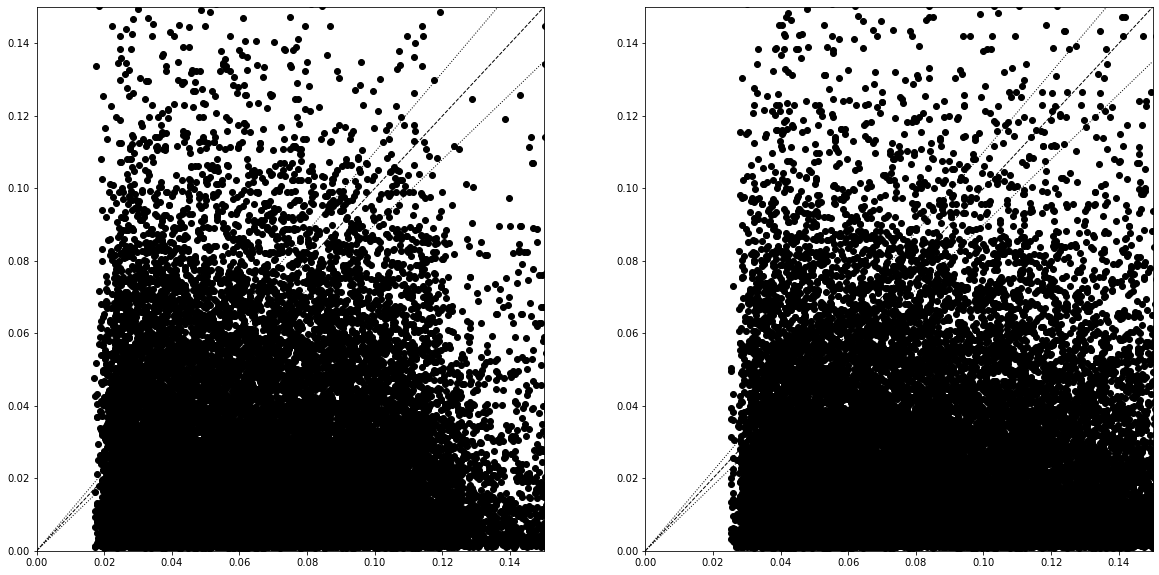

In [8]:
protons_Run_all             = np.array( np.concatenate( protons_Run_list ) )
protons_LumiSection_all     = np.array( np.concatenate( protons_LumiSection_list ) )
protons_BX_all              = np.array( np.concatenate( protons_BX_list ) )
protons_EventNum_all        = np.array( np.concatenate( protons_EventNum_list ) )
protons_CrossingAngle_all   = np.array( np.concatenate( protons_CrossingAngle_list ) )
protons_xi_all              = np.array( np.concatenate( protons_xi_list ) )
protons_ismultirp_all       = np.array( np.concatenate( protons_ismultirp_list ) )
protons_arm_all             = np.array( np.concatenate( protons_arm_list ) )
protons_rpid1_all           = np.array( np.concatenate( protons_rpid1_list ) )
protons_rpid2_all           = np.array( np.concatenate( protons_rpid2_list ) )
protons_trackx1_all         = np.array( np.concatenate( protons_trackx1_list ) )
protons_tracky1_all         = np.array( np.concatenate( protons_tracky1_list ) )
protons_trackx2_all         = np.array( np.concatenate( protons_trackx2_list ) )
protons_tracky2_all         = np.array( np.concatenate( protons_tracky2_list ) )
protons_Muon0Pt_all         = np.array( np.concatenate( protons_Muon0Pt_list ) )
protons_Muon0Eta_all        = np.array( np.concatenate( protons_Muon0Eta_list ) )
protons_Muon0Phi_all        = np.array( np.concatenate( protons_Muon0Phi_list ) )
protons_Muon0VtxZ_all       = np.array( np.concatenate( protons_Muon0VtxZ_list ) )
protons_Muon1Pt_all         = np.array( np.concatenate( protons_Muon1Pt_list ) )
protons_Muon1Eta_all        = np.array( np.concatenate( protons_Muon1Eta_list ) )
protons_Muon1Phi_all        = np.array( np.concatenate( protons_Muon1Phi_list ) )
protons_Muon1VtxZ_all       = np.array( np.concatenate( protons_Muon1VtxZ_list ) )
protons_PrimVertexZ_all     = np.array( np.concatenate( protons_PrimVertexZ_list ) )
protons_InvMass_all         = np.array( np.concatenate( protons_InvMass_list ) )
protons_nExtraPfCandPV3_all = np.array( np.concatenate( protons_nExtraPfCandPV3_list ) )
protons_Acopl_all           = np.array( np.concatenate( protons_Acopl_list ) )
protons_XiMuMuPlus_all      = np.array( np.concatenate( protons_XiMuMuPlus_list ) )
protons_XiMuMuMinus_all     = np.array( np.concatenate( protons_XiMuMuMinus_list ) )
print ( len( protons_xi_all ) )
print ( protons_Run_all )
print ( protons_LumiSection_all )
print ( protons_BX_all )
print ( protons_EventNum_all )
print ( protons_CrossingAngle_all )
print ( protons_xi_all )
print ( protons_ismultirp_all )
print ( protons_arm_all )
print ( protons_rpid1_all )
print ( protons_rpid2_all )
print ( protons_trackx1_all )
print ( protons_tracky1_all )
print ( protons_trackx2_all )
print ( protons_tracky2_all )
print ( protons_Muon0Pt_all )
print ( protons_Muon0Eta_all )
print ( protons_Muon0Phi_all )
print ( protons_Muon0VtxZ_all )
print ( protons_Muon1Pt_all )
print ( protons_Muon1Eta_all )
print ( protons_Muon1Phi_all )
print ( protons_Muon1VtxZ_all )
print ( protons_PrimVertexZ_all )
print ( protons_InvMass_all )
print ( protons_nExtraPfCandPV3_all )
print ( protons_Acopl_all )
print ( protons_XiMuMuPlus_all )
print ( protons_XiMuMuMinus_all )

msk_protons_1 = ( protons_ismultirp_all == 0 ) & ( protons_rpid1_all == 23)  
msk_protons_2 = ( protons_ismultirp_all == 0 ) & ( protons_rpid1_all == 123)  

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( protons_xi_all[ msk_protons_1 ], protons_XiMuMuPlus_all[ msk_protons_1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( protons_xi_all[ msk_protons_2 ], protons_XiMuMuMinus_all[ msk_protons_2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

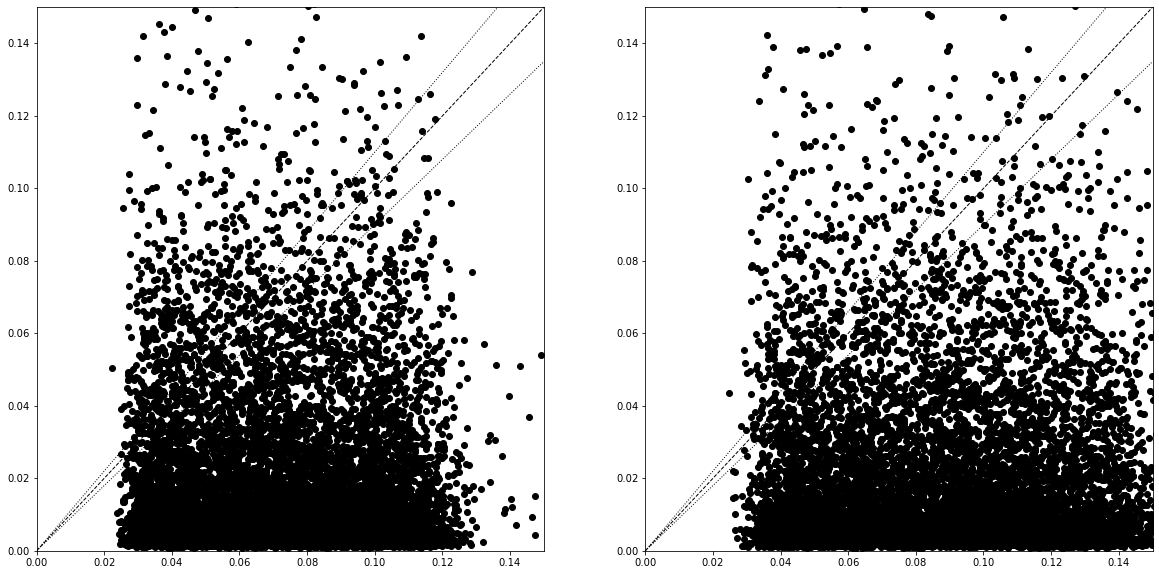

In [9]:
msk_protons_multirp_1 = ( protons_ismultirp_all == 1 ) & ( protons_arm_all == 0)
msk_protons_multirp_2 = ( protons_ismultirp_all == 1 ) & ( protons_arm_all == 1)

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( protons_xi_all[ msk_protons_multirp_1 ], protons_XiMuMuPlus_all[ msk_protons_multirp_1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( protons_xi_all[ msk_protons_multirp_2 ], protons_XiMuMuMinus_all[ msk_protons_multirp_2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

In [10]:
#fileNames = [
#    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root",
#    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017C1.root"
#]

In [11]:
#files_with_paths = [file + ":ggll_miniaod/ntp1" for file in fileNames]
#print ( files_with_paths )
#
#keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
#        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_istight",
#        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_ndof",
#        "nPfCand", "nRecoProtCand"]
#keys.extend( uproot4.open( files_with_paths[0] ).keys( filter_name="ProtCand*" ) )
#print ( keys )
#for events_ in uproot4.iterate( files_with_paths[0], keys, library="ak", how="zip" ):
#    print ( events_ )
#    print ( len(events_) )

In [12]:
#help(uproot4.iterate)

In [13]:
#help(uproot4.TTree.iterate)

In [14]:
#help(uproot4.TTree.arrays)

In [15]:
#help(uproot4.TTree.keys)

In [16]:
data_ = np.c_[
    protons_Run_all,
    protons_LumiSection_all,
    protons_BX_all,
    protons_EventNum_all,
    protons_CrossingAngle_all,
    protons_xi_all,
    protons_ismultirp_all,
    protons_arm_all,
    protons_rpid1_all,
    protons_rpid2_all,
    protons_trackx1_all,
    protons_tracky1_all,
    protons_trackx2_all,
    protons_tracky2_all,
    protons_Muon0Pt_all,
    protons_Muon0Eta_all,
    protons_Muon0Phi_all,
    protons_Muon0VtxZ_all,
    protons_Muon1Pt_all,
    protons_Muon1Eta_all,
    protons_Muon1Phi_all,
    protons_Muon1VtxZ_all,
    protons_PrimVertexZ_all,
    protons_InvMass_all,
    protons_nExtraPfCandPV3_all,
    protons_Acopl_all,
    protons_XiMuMuPlus_all,
    protons_XiMuMuMinus_all
    ]
print ( data_.shape )
columns_ = np.array( ("Run", "LumiSection", "BX", "EventNum", "CrossingAngle",
                      "Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2",
                      "Muon0Pt", "Muon0Eta", "Muon0Phi", "Muon0VtxZ", "Muon1Pt", "Muon1Eta", "Muon1Phi", "Muon1VtxZ",
                      "PrimVertexZ", "InvMass", "ExtraPfCands", "Acopl", "XiMuMuPlus", "XiMuMuMinus"), dtype='S' )
print ( columns_ )

event_counts_ = counts
print ( event_counts_ )
selections_ = np.array( selections, dtype='S' )
print ( selections_ )

(107075, 28)
[b'Run' b'LumiSection' b'BX' b'EventNum' b'CrossingAngle' b'Xi' b'MultiRP'
 b'Arm' b'RPId1' b'RPId2' b'TrackX1' b'TrackY1' b'TrackX2' b'TrackY2'
 b'Muon0Pt' b'Muon0Eta' b'Muon0Phi' b'Muon0VtxZ' b'Muon1Pt' b'Muon1Eta'
 b'Muon1Phi' b'Muon1VtxZ' b'PrimVertexZ' b'InvMass' b'ExtraPfCands'
 b'Acopl' b'XiMuMuPlus' b'XiMuMuMinus']
[47151 44057 32009]
[b'Muon' b'Vertex' b'Protons']


In [17]:
with h5py.File('output-test.h5', 'w') as f:
    dset = f.create_dataset( 'protons', data=data_ )
    dset_columns = f.create_dataset( 'columns', data=columns_ )
    dset_counts = f.create_dataset( 'event_counts', data=event_counts_ )
    dset_selections = f.create_dataset( 'selections', data=selections_ )
    print ( dset )
    print ( dset[-1] )   
    print ( dset_columns )
    print ( list( dset_columns ) )
    print ( dset_counts )
    print ( list( dset_counts ) )
    print ( dset_selections )
    print ( list( dset_selections ) )
    

<HDF5 dataset "protons": shape (107075, 28), type "<f8">
[ 2.99062000e+05  1.33000000e+02  1.72100000e+03  2.26402907e+08
  1.40000000e+02  1.74899608e-01  1.00000000e+00  1.00000000e+00
  1.03000000e+02  1.23000000e+02  4.39575195e+00  2.39990234e+00
  3.59982300e+00  2.42749023e+00  1.59034851e+02 -1.54594707e+00
  9.34277236e-01 -3.90081906e+00  5.31496010e+01 -1.49731851e+00
  1.98727989e+00 -3.90096545e+00 -3.90147352e+00  9.25081731e+01
  1.90000000e+01  6.64818845e-01  3.52177158e-03  7.56784159e-02]
<HDF5 dataset "columns": shape (28,), type "|S13">
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlus', b'XiMuMuMinus']
<HDF5 dataset "event_counts": shape (3,), type "<i8">
[47151, 44057, 32009]
<HDF5 datase

In [18]:
df = None
with h5py.File('output-test.h5', 'r') as f:
#with h5py.File('output-UL2017B.h5', 'r') as f:
#with h5py.File('output/output-UL2017B-Excl.h5', 'r') as f:
#with h5py.File('output/output-UL2017B-PreSel.h5', 'r') as f:    
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns_ = list( dset_columns )
    print ( columns_ )
    columns_str = [ item.decode("utf-8") for item in columns_ ]
    print ( columns_str )
    dset_counts = f['event_counts']
    event_counts_ = list( dset_counts )
    print ( event_counts_ )
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str )
    
    #df = pd.DataFrame( dset, columns=("Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2", "XAngle", "XiMuMuPlus", "XiMuMuMinus") )
    #df = pd.DataFrame( dset, columns=("Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2", "XAngle", "InvMass", "ExtraPfCands", "Acopl", "XiMuMuPlus", "XiMuMuMinus") )
    df = pd.DataFrame( dset, columns=columns_str )
    print ( df )


['columns', 'event_counts', 'protons', 'selections']
(107075, 28)
[[2.97227000e+05 5.30000000e+01 2.29700000e+03 ... 9.83012105e-01
  5.61954090e-02 4.09129155e-03]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 ...
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]]
(28,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlu

In [19]:
df

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,297227.0,53.0,2297.0,36577201.0,120.0,0.029290,0.0,-999.0,123.0,-1.0,...,63.807861,1.228711,-2.968801,7.642523,7.640311,12.129827,48.0,0.983012,0.056195,0.004091
1,297227.0,55.0,867.0,38079658.0,120.0,0.055317,0.0,-999.0,103.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
2,297227.0,55.0,867.0,38079658.0,120.0,0.053598,0.0,-999.0,123.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
3,297227.0,55.0,867.0,38079658.0,120.0,0.067306,1.0,1.0,103.0,123.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
4,297227.0,56.0,1102.0,38791639.0,120.0,0.098331,0.0,-999.0,103.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
5,297227.0,56.0,1102.0,38791639.0,120.0,0.097884,0.0,-999.0,123.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
6,297227.0,56.0,1102.0,38791639.0,120.0,0.102869,1.0,1.0,103.0,123.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
7,297227.0,56.0,378.0,38604580.0,120.0,0.037838,0.0,-999.0,3.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210
8,297227.0,56.0,378.0,38604580.0,120.0,0.038086,0.0,-999.0,23.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210
9,297227.0,56.0,378.0,38604580.0,120.0,0.043100,0.0,-999.0,103.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210


In [20]:
#( df["MultiRP"] == 0) & ( df["RPId1"] == 23 )
msk = ( df["MultiRP"] == 1) & ( df["Arm"] == 0 )
#msk = ( df["MultiRP"] == 1) & ( df["Arm"] == 1 )
df[ msk ]

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
11,297227.0,56.0,378.0,3.860458e+07,120.0,0.036897,1.0,0.0,3.0,23.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210
22,297227.0,59.0,2938.0,4.060116e+07,120.0,0.029943,1.0,0.0,3.0,23.0,...,50.114189,0.947750,-2.091486,-2.064680,-2.062503,105.095469,20.0,0.052973,0.025162,0.002618
33,297227.0,70.0,1002.0,4.990410e+07,120.0,0.067364,1.0,0.0,3.0,23.0,...,53.105831,-0.329116,-0.533099,-0.216218,-0.215819,93.213809,80.0,0.665581,0.003924,0.027699
39,297227.0,71.0,517.0,5.068703e+07,120.0,0.039614,1.0,0.0,3.0,23.0,...,113.611771,-1.225648,2.078576,3.568076,3.565264,270.992400,27.0,0.016921,0.010428,0.041786
61,297227.0,75.0,1035.0,5.344936e+07,120.0,0.104492,1.0,0.0,3.0,23.0,...,62.750038,-0.170203,-2.517309,0.089492,0.094468,159.699672,53.0,0.023202,0.019344,0.007848
64,297227.0,75.0,75.0,5.388658e+07,120.0,0.051632,1.0,0.0,3.0,23.0,...,50.371296,-0.917533,-2.966093,-4.776505,-4.777870,101.382085,35.0,0.479861,0.002917,0.038428
67,297227.0,76.0,1424.0,5.440056e+07,120.0,0.083855,1.0,0.0,3.0,23.0,...,57.129417,1.468851,-0.610778,-0.688583,-0.674970,92.318142,8.0,0.969707,0.039767,0.008109
85,297227.0,85.0,3212.0,6.157367e+07,120.0,0.058042,1.0,0.0,3.0,23.0,...,59.928143,-0.523357,2.168831,-1.712266,-1.711951,91.613210,28.0,0.493859,0.007161,0.013032
97,297227.0,90.0,387.0,6.547110e+07,120.0,0.067216,1.0,0.0,3.0,23.0,...,56.725800,-0.954645,-1.449844,0.197195,0.195521,91.919272,53.0,0.414651,0.003760,0.020915
104,297227.0,93.0,1070.0,6.748409e+07,120.0,0.079165,1.0,0.0,3.0,23.0,...,50.502056,1.297320,1.591901,-3.689770,-3.695563,102.103084,7.0,0.018619,0.026568,0.002324


(0.0, 0.15)

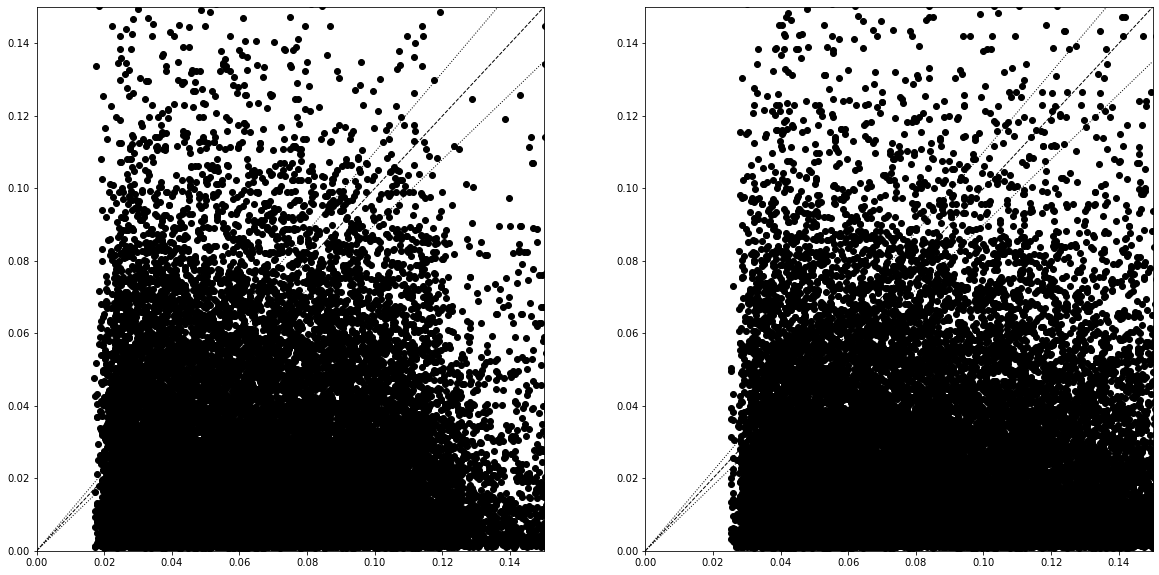

In [21]:
msk1 = ( df["MultiRP"] == 0) & ( df["RPId1"] == 23 )
msk2 = ( df["MultiRP"] == 0) & ( df["RPId1"] == 123 )
#msk1 = ( df["MultiRP"] == 1) & ( df["Arm"] == 0 )
#msk2 = ( df["MultiRP"] == 1) & ( df["Arm"] == 1 )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( df[ "Xi" ][ msk1 ], df[ "XiMuMuPlus" ][ msk1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df[ "Xi" ][ msk2 ], df[ "XiMuMuMinus" ][ msk2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)